In [1]:
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

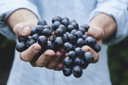

In [2]:
from PIL import Image
path = 'images/'
im = Image.open(path + 'grape/grape-0.jpg')
im.to_thumb(128,128)

In [3]:
from fastai.vision.all import *
filenames = get_image_files(path)
filenames

(#3967) [Path('images/apple/apple-fruit-81.jpg'),Path('images/apple/apple-fruit-293.jpg'),Path('images/apple/apple-fruit-287.jpg'),Path('images/apple/apple-fruit-95.jpg'),Path('images/apple/apple-fruit-250.jpg'),Path('images/apple/apple-fruit-42.jpg'),Path('images/apple/apple-fruit-536.jpg'),Path('images/apple/apple-fruit-522.jpg'),Path('images/apple/apple-fruit-56.jpg'),Path('images/apple/apple-fruit-244.jpg')...]

In [4]:
failed = verify_images(filenames)
failed

(#0) []

In [5]:
fruits = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [6]:
dls = fruits.dataloaders(path)

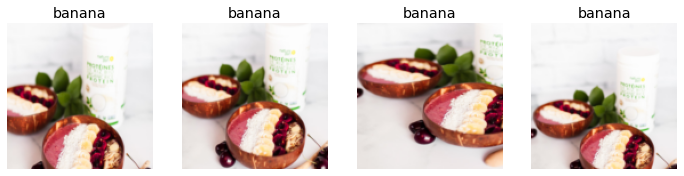

In [8]:
fruits = fruits.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = fruits.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [9]:
our_out_of_the_box_model = cnn_learner(dls, resnet50, metrics=error_rate)
our_out_of_the_box_model.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/driaug/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 23.4MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.806215,1.615836,0.390921,06:22


epoch,train_loss,valid_loss,error_rate,time
0,1.262197,1.235389,0.354351,07:53
1,1.061892,1.122893,0.327869,08:06
2,0.773215,0.950971,0.293821,08:40
3,0.595114,0.938026,0.291299,08:32


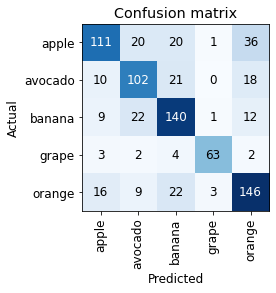

In [10]:
interp = ClassificationInterpretation.from_learner(our_out_of_the_box_model)
interp.plot_confusion_matrix()

In [12]:
our_out_of_the_box_model.save('model')
our_out_of_the_box_model.export()